**ANÁLISIS**

**1. Preparación del entorno**

In [6]:
try:
  from google.colab import auth
  auth.authenticate_user()
  import pandas as pd
except:
  !pip install google-cloud-storage
  !pip install pandas

from google.cloud import storage
import pandas as pd
import numpy as np
import random
import string
import regex as re
import nltk
import matplotlib.pyplot as plt
!pip install emoji
import emoji

!pip install unidecode
from unidecode import unidecode
!pip install num2words
from num2words import num2words
!pip install wordcloud
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
stopwords_es = stopwords.words('spanish')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def descargar_de_bucket_origen(nombre_bucket_origen, nombre_blob_origen, nombre_archivo_destino):
    cliente = storage.Client()
    bucket = cliente.bucket(nombre_bucket_origen)
    blob = bucket.blob(nombre_blob_origen)
    blob.download_to_filename(nombre_archivo_destino)
    print(f"Archivo {nombre_blob_origen} descargado como {nombre_archivo_destino}.")

def subir_a_bucket_destino(nombre_bucket_procesado, nombre_archivo_destino, nombre_blob_destino):
    cliente = storage.Client()
    bucket = cliente.bucket(nombre_bucket_procesado)
    blob = bucket.blob(nombre_blob_destino)
    # Verificar si el archivo ya existe en el bucket
    if blob.exists():
        print(f"El archivo {nombre_blob_destino} ya existe en el bucket {nombre_bucket_procesado} y no se ha subido por no sobreescribirlo y preservar los datos, pon otro nombre o solicita ayuda al administrador del bucket.")
    else:
        blob.upload_from_filename(nombre_archivo_destino)
        print(f"Archivo {nombre_archivo_destino} subido a {nombre_blob_destino} en el bucket {nombre_bucket_procesado}.")

def random_df(df, n):
    total_rows = len(df)
    random_indices = random.sample(range(total_rows), n)
    df_random = df.iloc[random_indices]
    return df_random

def count_emoji(text):
    if isinstance(text, str):
        try:
            emoji_regex = re.compile("["
                u"\U0001F600-\U0001F64F"  # Emoticonos y expresiones faciales
                u"\U0001F300-\U0001F5FF"  # Símbolos y pictogramas
                u"\U0001F680-\U0001F6FF"  # Transporte y símbolos de mapa
                u"\U0001F3B5-\U0001F3EF"  # Símbolos de nota musical
                u"\U0001F700-\U0001F77F"  # Símbolos alquímicos
                u"\U0001F7E0-\U0001F7EB"  # Símbolos matemáticos
                u"\U0001F0A0-\U0001F0FF"  # Símbolos de cartas de juego
                u"\U0001F000-\U0001F02F"  # Símbolos de mahjong
                u"\U0001F030-\U0001F09F"  # Símbolos de puntuación y flechas
                u"\U0001F200-\U0001F2FF"  # Símbolos de estilo tipográfico
                                   "]+", flags=re.UNICODE)
            found_emoji = emoji_regex.findall(text)
            num_emoji = len(found_emoji)
            return num_emoji
        except Exception as e:
            print(f"Error al contar emoticonos: {e}")
            return 0
    else:
        return 0

def contains_emoticon(text):
    emoticon_regex = r'[^\w\s,]'
    return bool(re.search(emoticon_regex, text))

def remove_usernames(text):
    username_pattern = r'@[A-Za-z0-9_]+'
    username_pattern = re.sub(username_pattern, '', text)
    username_pattern = re.sub(r'\s+', ' ', username_pattern).strip()
    return username_pattern

def without_punctuation(text):
    table = (str.maketrans('', '', string.punctuation))
    clean_text = text.translate(table).lower()
    clean_text = unidecode(clean_text)
    return clean_text

def convert_num_to_words(text):
    words = text.split()
    return ' '.join([num2words(word, lang='en', ordinal=False) if word.isdigit() else word for word in words])

def calcul_cardinality(text):
    words = word_tokenize(text)  # Tokenizar el texto
    return len(set(words))

def obtain_ngrams(text, n=2, num=10):
    words = word_tokenize(text.lower())
    n_grams = [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
    frequency = FreqDist(n_grams)
    return frequency.most_common(num)

**2. Cargar datos**

In [11]:
nombre_bucket_origen = 'ds-edw-raw-d1655b14'
nombre_bucket_procesado = 'ds-edw-processed-d1655b14'

nombre_blob_origen_a = 'dataset/hascosva_2022.csv'
nombre_blob_origen_b = 'dataset/hsd_merge_cleaned_lowered.csv'
nombre_blob_origen_c = 'dataset/Spain_test.csv'
nombre_blob_origen_d = 'dataset/Hate_Speech_in_Spain.csv'

ruta_descarga_local_a = 'hascosva_2022.csv'
ruta_descarga_local_b = 'hsd_merge_cleaned_lowered.csv'
ruta_descarga_local_c = 'Spain_test.csv'
ruta_descarga_local_d = 'Hate_Speech_in_Spain.csv'

descargar_de_bucket_origen(nombre_bucket_origen, nombre_blob_origen_a, ruta_descarga_local_a)
descargar_de_bucket_origen(nombre_bucket_origen, nombre_blob_origen_b, ruta_descarga_local_b)
descargar_de_bucket_origen(nombre_bucket_origen, nombre_blob_origen_c, ruta_descarga_local_c)
descargar_de_bucket_origen(nombre_bucket_origen, nombre_blob_origen_d, ruta_descarga_local_d)

# Trabajamos con el CSV y hacemos lo que haya que hacer con la fuente
file_a = pd.read_csv(ruta_descarga_local_a)
file_b = pd.read_csv(ruta_descarga_local_b)
file_c = pd.read_csv(ruta_descarga_local_c)
file_d = pd.read_csv(ruta_descarga_local_d)

Archivo dataset/hascosva_2022.csv descargado como hascosva_2022.csv.
Archivo dataset/hsd_merge_cleaned_lowered.csv descargado como hsd_merge_cleaned_lowered.csv.
Archivo dataset/Spain_test.csv descargado como Spain_test.csv.
Archivo dataset/Hate_Speech_in_Spain.csv descargado como Hate_Speech_in_Spain.csv.


**3. EDA**

In [12]:
# Creación del dataframe
df_a = pd.DataFrame(file_a)
df_a_random = [random_df(df_a, 4)]

df_b = pd.DataFrame(file_b)
df_b_random = [random_df(df_b, 4)]

df_c = pd.DataFrame(file_c)
df_c_random = [random_df(df_c, 4)]

df_d = pd.DataFrame(file_d)
df_d_random = [random_df(df_d, 4)]

print(df_a_random)
print("." * 20)


[                                                   text  label variation
2674  @Newtral me parece sumamente ofensivo el uso d...      0    europe
1986  "📌 Tiradores senegaleses, el cuerpo de infante...      0    europe
1873  La Red Solidaria de nuestro Centro clausuró es...      0    europe
3316  Procedente del Lions Gibraltar FC de la Primer...      0    europe]
....................


In [13]:
# Concatenación de dataframes
df = pd.concat([df_a, df_b, df_c, df_d], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30288 entries, 0 to 30287
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   text        30287 non-null  object 
 1   label       30288 non-null  float64
 2   variation   4000 non-null   object 
 3   Unnamed: 0  1243 non-null   float64
dtypes: float64(2), object(2)
memory usage: 946.6+ KB


In [14]:
# Eliminación de columnas
df = df.drop(['variation', 'Unnamed: 0'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30288 entries, 0 to 30287
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    30287 non-null  object 
 1   label   30288 non-null  float64
dtypes: float64(1), object(1)
memory usage: 473.4+ KB


In [15]:
# Convertir a int64
df['label'] = df['label'].astype('int64')
df.head(4)

,text,label
0,Avión venezolano: ocho tripulantes coinciden e...,0
1,Aquí pidiéndole consejos al amigo veneco pa so...,0
2,@DianaDvilaNarv1 Cínicos desinforman con guión...,0
3,@DianAngel01 No se chama dime tu 🤭🤭🤣😛😅😅,0


In [16]:
print(df.shape)

(30288, 2)


In [17]:
csv_tratado = 'df_concat.csv'
df.to_csv(csv_tratado, index=False)

nombre_blob_destino = 'CSV/processed/df_concat.csv' # Acordaos de cambiar el nombre por el que corresponda
subir_a_bucket_destino(nombre_bucket_procesado, csv_tratado, nombre_blob_destino)

Archivo df_concat.csv subido a CSV/processed/df_concat.csv en el bucket ds-edw-processed-d1655b14.


In [18]:
# Analisis de emoji
df['num_emoji'] = df['text'].apply(count_emoji)
total_emoji = df['num_emoji'].sum()
registration_num_emoji = (df['num_emoji'] > 0).sum()
percent_with_emoji = (registration_num_emoji / (len(df))) * 100
percent_with_emoji = '{:.2f}%'.format(percent_with_emoji)

print(f'El número total de registros en el DataFrame es: {len(df)}')
print(f'El número total de emoticonos en el DataFrame es: {total_emoji}')
print(f'El número de registros que contienen al menos un emoticono es: {registration_num_emoji}')
print(f'El % de registros que contienen emoticonos es: {percent_with_emoji}')

El número total de registros en el DataFrame es: 30288
El número total de emoticonos en el DataFrame es: 3073
El número de registros que contienen al menos un emoticono es: 2403
El % de registros que contienen emoticonos es: 7.93%


In [19]:
# Filtrar filas sin emoticonos
df = df[df['num_emoji'] == 0].copy()
df = df.drop(columns=['num_emoji'])

print("\nDataFrame filtrado sin filas que contienen emoticonos:")
print(df)


DataFrame filtrado sin filas que contienen emoticonos:
                                                    text  label
0      Avión venezolano: ocho tripulantes coinciden e...      0
1      Aquí pidiéndole consejos al amigo veneco pa so...      0
2      @DianaDvilaNarv1 Cínicos desinforman con guión...      0
4      Gobierno de Bélgica ustedes que albergan a Raf...      0
6      Y esto es lo que pasa cuando dejas a auténtico...      0
...                                                  ...    ...
30283                                   sacar una mierda      1
30284                                       vacas gordas      1
30285                         vacuna contra pedrosanchez      1
30286                           discursos catastrofistas      1
30287                               enchufados politicos      1

[27885 rows x 2 columns]


In [20]:
# Revisión de valores NA
df.isna().sum()

text     1
label    0
dtype: int64

In [21]:
df = df.dropna()
df.isna().sum()

text     0
label    0
dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27884 entries, 0 to 30287
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27884 non-null  object
 1   label   27884 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 653.5+ KB


In [23]:
# Eliminación de nombres de usuarios
df['text'] = df['text'].apply(remove_usernames)
df.head()

,text,label
0,Avión venezolano: ocho tripulantes coinciden e...,0
1,Aquí pidiéndole consejos al amigo veneco pa so...,0
2,"Cínicos desinforman con guión preparado, ecena...",0
4,Gobierno de Bélgica ustedes que albergan a Raf...,0
6,Y esto es lo que pasa cuando dejas a auténtico...,0


In [24]:
# Eliminación signos de puntuación y paso de mayusculas a minusculas
df['text'] = df['text'].apply(without_punctuation)
df.head()

,text,label
0,avion venezolano ocho tripulantes coinciden en...,0
1,aqui pidiendole consejos al amigo veneco pa so...,0
2,cinicos desinforman con guion preparado ecena ...,0
4,gobierno de belgica ustedes que albergan a raf...,0
6,y esto es lo que pasa cuando dejas a autentico...,0


In [25]:
# Convertir números a letras
df['text'] = df['text'].apply(convert_num_to_words)
df.head()

,text,label
0,avion venezolano ocho tripulantes coinciden en...,0
1,aqui pidiendole consejos al amigo veneco pa so...,0
2,cinicos desinforman con guion preparado ecena ...,0
4,gobierno de belgica ustedes que albergan a raf...,0
6,y esto es lo que pasa cuando dejas a autentico...,0


In [26]:
# Cardinalidad del vocabulario para cada comentario
df['cardinalidad_vocabulario'] = df['text'].apply(calcul_cardinality)
df.head()

,text,label,cardinalidad_vocabulario
0,avion venezolano ocho tripulantes coinciden en...,0,13
1,aqui pidiendole consejos al amigo veneco pa so...,0,9
2,cinicos desinforman con guion preparado ecena ...,0,10
4,gobierno de belgica ustedes que albergan a raf...,0,32
6,y esto es lo que pasa cuando dejas a autentico...,0,29


In [27]:
# Recuento en la columna que define si es de odio o no
distribucion_comentarios = df['label'].value_counts().sort_index()
print("Distribución de comentarios 0 = No odio, 1= Si odio:")
print(distribucion_comentarios)

Distribución de comentarios 0 = No odio, 1= Si odio:
label
0    16804
1    11080
Name: count, dtype: int64


In [28]:
# Se crean nuevas columnas que ayuden  a comprender el dataset
df['Longitud del Comentario'] = df['text'].apply(lambda x: len(str(x)))

df['Recuento de Palabras'] = df['text'].apply(lambda x: len(str(x).split()))

print(df.head())

                                                text  label  \
0  avion venezolano ocho tripulantes coinciden en...      0   
1  aqui pidiendole consejos al amigo veneco pa so...      0   
2  cinicos desinforman con guion preparado ecena ...      0   
4  gobierno de belgica ustedes que albergan a raf...      0   
6  y esto es lo que pasa cuando dejas a autentico...      0   

   cardinalidad_vocabulario  Longitud del Comentario  Recuento de Palabras  
0                        13                       99                    13  
1                         9                       68                    10  
2                        10                       98                    10  
4                        32                      261                    38  
6                        29                      203                    33  


In [29]:
ngrams_frecuentes = obtain_ngrams(df['text'].str.cat(sep=' '))
print("N-grams más frecuentes:")
print(ngrams_frecuentes)

N-grams más frecuentes:
[(('de', 'la'), 2060), (('a', 'la'), 1259), (('a', 'los'), 1166), (('en', 'el'), 1127), (('de', 'los'), 1119), (('en', 'la'), 1060), (('que', 'no'), 1050), (('lo', 'que'), 913), (('que', 'se'), 809), (('no', 'se'), 640)]


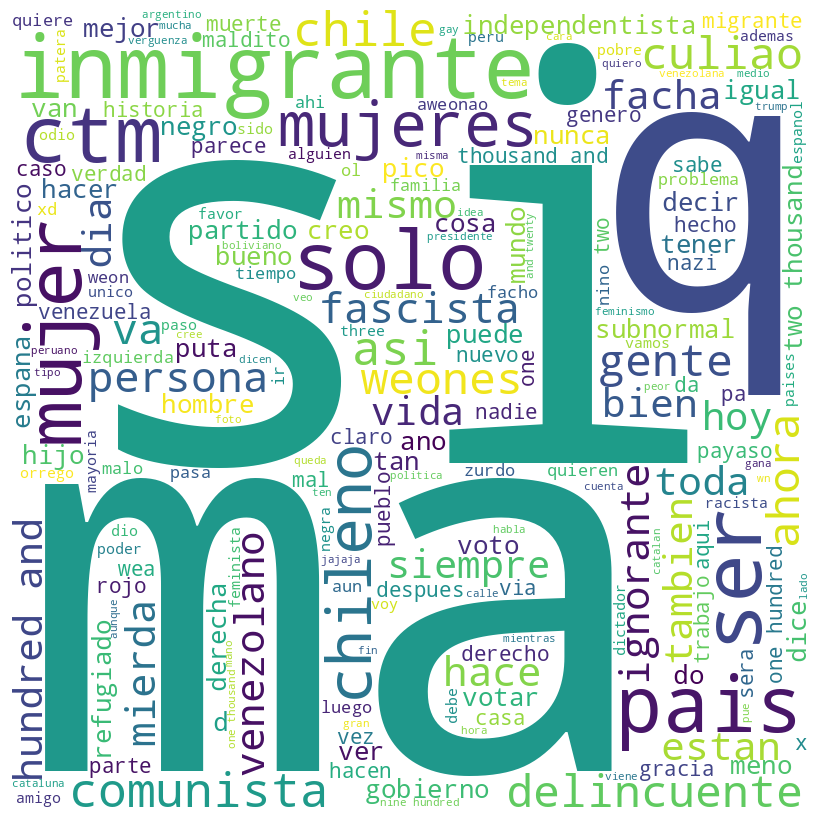

In [30]:
comentarios_0 = " ".join(df[df['label'] == 0]['text'])

# Crear la nube de palabras para comentarios clasificados como 0
wordcloud_0 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords_es,
                min_font_size = 10).generate(comentarios_0)

# Mostrar la nube de palabras para comentarios clasificados como 0
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_0)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

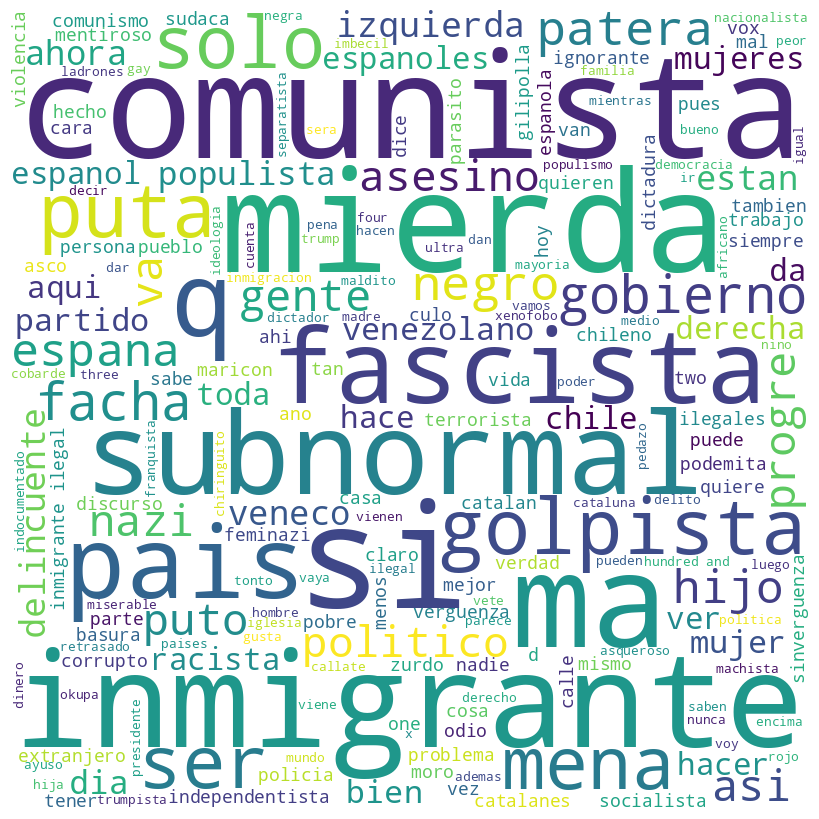

In [31]:
comentarios_1 = " ".join(df[df['label'] == 1]['text'])

# Crear la nube de palabras para comentarios clasificados como 1
wordcloud_1 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords_es,
                min_font_size = 10).generate(comentarios_1)

# Mostrar la nube de palabras para comentarios clasificados como 1
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_1)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [33]:
csv_tratado = 'df_analisis.csv'
df.to_csv(csv_tratado, index=False)

nombre_blob_destino = 'CSV/df_analisis.csv' # Acordaos de cambiar el nombre por el que corresponda
subir_a_bucket_destino(nombre_bucket_origen, csv_tratado, nombre_blob_destino)

El archivo CSV/df_analisis.csv ya existe en el bucket ds-edw-raw-d1655b14 y no se ha subido por no sobreescribirlo y preservar los datos, pon otro nombre o solicita ayuda al administrador del bucket.
